<a href="https://colab.research.google.com/github/Rickmwasofficial/Learning-Machine-Learning/blob/main/Transfer_Learning_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning with tensorflow Pt.3 (scaling up)

## FoodVision Mini

We have seen the power of transfer learning, now we will scale our data to all the 101 classes of food101

Our goal is to beat the results of the food101 paper only on 10 percent of the data 50.76 % Accuracy

In [1]:
!nvidia-smi

Thu Aug 22 21:13:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Get the helper functions
!wget https://raw.githubusercontent.com/Rickmwasofficial/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-22 22:55:17--  https://raw.githubusercontent.com/Rickmwasofficial/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-22 22:55:17 (66.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir

In [4]:
# Lets get the dataand unzip it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2024-08-22 22:55:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  92.7MB/s    in 23s     

2024-08-22 22:55:47 (66.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_c

In [6]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [7]:
## Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    shuffle = False # Don't shuffle for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train The FVM(food_vision_mini) model

1. Set up Model checkpoint callback
2. Create a data augmentation layer to build data augmentation right into the model.
3. Build a topless functional EfficientNetB0 backboned model. We'll create our own output.
4. Compile our model
5. Feature extract for five epochs
6. Test on 15% of the test data to reduce training time

In [12]:
# create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    save_best_only = True
)

In [15]:
# Creating our data augmentation layer
from tensorflow.keras import layers

data_augmentation = tf.keras.models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2)
])

In [16]:
# Build a topless model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)

outputs = layers.Dense(len(train_data_all.class_names), activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model_1.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
hist_1 = model_1.fit(
    train_data_all,
    epochs = 5,
    validation_data = test_data_all,
    validation_steps = int(0.15 * len(test_data_all)),
    callbacks = [create_tensorboard_callback(dir_name='10_percent_101_data',
                                             experiment_name='feature_extraction_101_classes'),
                 checkpoint_callback]
)

Saving TensorBoard log files to: 10_percent_101_data/feature_extraction_101_classes/20240822-215542
Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.1321 - loss: 4.0709 - val_accuracy: 0.3398 - val_loss: 2.8530
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - accuracy: 0.4233 - loss: 2.5902 - val_accuracy: 0.4380 - val_loss: 2.2400
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - accuracy: 0.4822 - loss: 2.1716 - val_accuracy: 0.5416 - val_loss: 1.8696
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.5360 - loss: 1.9678 - val_accuracy: 0.5458 - val_loss: 1.8135
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.5615 - loss: 1.8074 - val_accuracy: 0.5792 - val_loss: 1.6760


In [18]:
# Let's evaluate on the whole test data set
model_1.evaluate(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5015 - loss: 1.9142


[1.8186659812927246, 0.5289505124092102]

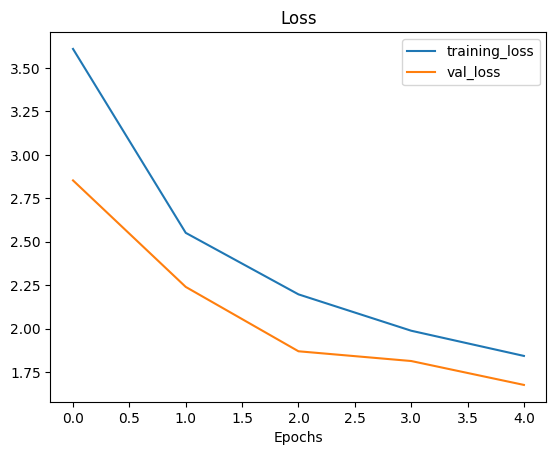

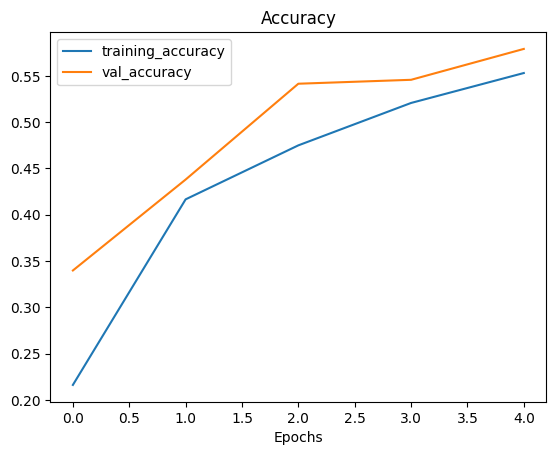

In [19]:
plot_loss_curves(hist_1)

# Fine Tuning

We have already acheived our goal of beating the baseline model of the food101 paper

In [20]:

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


In [21]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [24]:
for layer in model_1.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=sequential_2, built=True> True
<Functional name=efficientnetb0, built=True> True
<GlobalAveragePooling2D name=global_average_pooling, built=True> True
<Dense name=output_layer, built=True> True


In [25]:
# compile the model again
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 910,821 (3.47 MB)

 Non-trainable params: 3,268,131 (12.47 MB)

In [28]:
hist_2 = model_1.fit(
    train_data_all,
    epochs = 10,
    validation_data = test_data_all,
    validation_steps = int(0.15 * len(test_data_all)),
    callbacks = [create_tensorboard_callback(dir_name='10_percent_101_data', experiment_name='fine_tune_101_classes')],
    initial_epoch = hist_1.epoch[-1]
)

Saving TensorBoard log files to: 10_percent_101_data/fine_tune_101_classes/20240822-222041
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.5675 - loss: 1.7949 - val_accuracy: 0.4899 - val_loss: 1.9680
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 173ms/step - accuracy: 0.6178 - loss: 1.5678 - val_accuracy: 0.5281 - val_loss: 1.7737
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.6339 - loss: 1.5036 - val_accuracy: 0.5874 - val_loss: 1.6269
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.6548 - loss: 1.4049 - val_accuracy: 0.5665 - val_loss: 1.6584
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.6515 - loss: 1.3760 - val_accuracy: 0.6295 - val_loss: 1.4185
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.6717 - loss: 1.2932 - val_accuracy: 0.6094 - val_loss: 1.4118


In [29]:
model_1.evaluate(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5476 - loss: 1.7198


[1.6158465147018433, 0.5720791816711426]

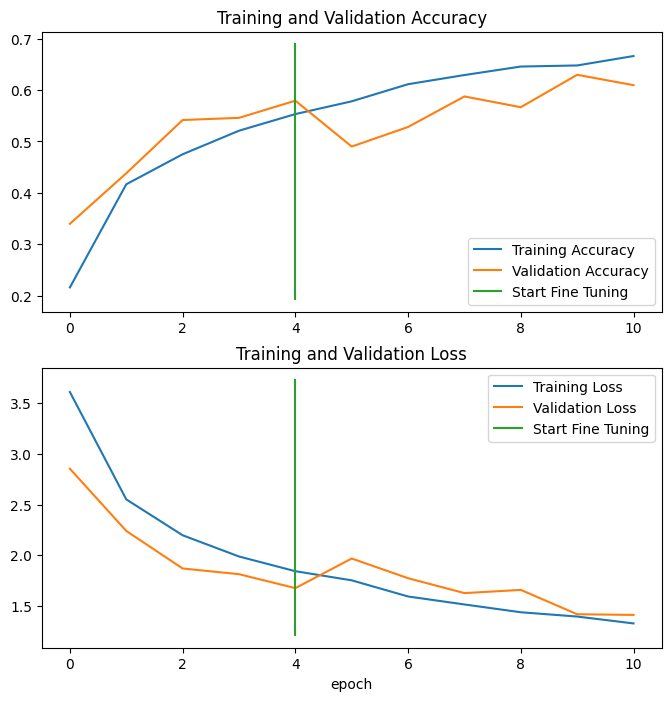

In [31]:
compare_historys(hist_1, hist_2, initial_epochs=5)

In [33]:
# Saving and Loading our model
model_1.save('drive/MyDrive/mini_food_vision_EfficientNetB0.keras')

In [8]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/mini_food_vision_EfficientNetB0.keras')

## Evaluating the perfomance of MFV Across different classes

We will then find out which was the most wrong

In [35]:
# We will use the pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

--2024-08-22 22:40:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  10.6MB/s    in 4.8s    

2024-08-22 22:40:54 (9.37 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



## Making Predictions with our model


In [9]:
pred_probs = loaded_model.predict(test_data_all, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 1940s 2s/step


In [10]:
pred_probs.shape

(25250, 101)

In [11]:
pred_probs[:2]

array([[1.92895651e-01, 1.50005729e-03, 7.88636655e-02, 2.07796097e-06,
        1.04342607e-05, 2.39571455e-05, 4.31249617e-04, 8.46207040e-05,
        1.14833750e-02, 9.30030074e-04, 2.50658195e-05, 9.49780297e-05,
        3.00400262e-03, 1.40234088e-05, 7.81385694e-03, 4.67935140e-04,
        5.55203333e-05, 9.98936361e-04, 5.98129723e-03, 5.89685042e-05,
        2.37166602e-03, 1.15896713e-04, 1.27345294e-04, 1.22528116e-03,
        7.43056517e-05, 4.25518025e-03, 2.50059040e-03, 3.09958734e-04,
        7.02083334e-02, 7.58435985e-04, 4.18746504e-06, 1.63087901e-03,
        4.06715815e-04, 1.79927665e-04, 1.15528633e-03, 2.89112329e-04,
        1.27709738e-03, 5.36932936e-03, 1.71282906e-02, 3.93590781e-05,
        1.47008788e-04, 1.83094502e-03, 6.09387597e-03, 2.10304701e-04,
        2.26591670e-04, 3.05545545e-05, 6.12575444e-04, 1.73629916e-04,
        6.17720652e-05, 5.96345663e-02, 7.81629235e-03, 2.62346410e-04,
        1.49548098e-01, 1.37574017e-01, 9.48062589e-05, 1.801733

In [12]:
# Get the predicetd class of all samples
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 80, 53, 78, 29, 62,  9,  0])

### Now we've got the predicted classes, we should get the true claasses in the test data

To get our test_labels we need to unbatchify our test data

In [13]:
y_labels = []
for images, labels in test_data_all.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

One way to check that our model's predictions array is the same order as our test labels is finding the accuracy score

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_labels, pred_classes)

0.5520396039603961

In [17]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.xticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [18]:
# Now let's create a confunsion matrix for our model

make_confusion_matrix(y_labels, pred_classes, classes=test_data_all.class_names, figsize=(100, 100), savefig=True)

Scikit learn has a helpful function for acquiring many metrics for a class eg pricision, f1 called classification_report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(pred_classes, y_labels))

              precision    recall  f1-score   support

           0       0.16      0.30      0.21       137
           1       0.74      0.40      0.52       460
           2       0.32      0.82      0.46        96
           3       0.46      0.80      0.58       143
           4       0.50      0.50      0.50       251
           5       0.31      0.40      0.35       195
           6       0.59      0.84      0.69       176
           7       0.75      0.72      0.74       261
           8       0.42      0.31      0.36       340
           9       0.63      0.40      0.49       393
          10       0.42      0.42      0.42       245
          11       0.45      0.85      0.59       132
          12       0.55      0.70      0.62       195
          13       0.62      0.36      0.46       429
          14       0.53      0.52      0.52       258
          15       0.26      0.52      0.35       126
          16       0.44      0.74      0.56       149
          17       0.39    

In [21]:
# Let's create a plot of all different class and their f1 score
classification_reports = classification_report(pred_classes, y_labels, output_dict=True)

In [22]:
# Create empty dict
class_f1score = {}

for k, v in classification_reports.items():
  if k == 'accuracy':
    break
  else:
    class_f1score[test_data_all.class_names[int(k)]] = v['f1-score']

class_f1score

{'apple_pie': 0.21188630490956073,
 'baby_back_ribs': 0.5211267605633803,
 'baklava': 0.4566473988439307,
 'beef_carpaccio': 0.5801526717557252,
 'beef_tartare': 0.5029940119760479,
 'beet_salad': 0.35056179775280905,
 'beignets': 0.6901408450704225,
 'bibimbap': 0.7358121330724069,
 'bread_pudding': 0.3593220338983051,
 'breakfast_burrito': 0.49144634525660963,
 'bruschetta': 0.42020202020202024,
 'caesar_salad': 0.5863874345549738,
 'cannoli': 0.6157303370786518,
 'caprese_salad': 0.4565537555228277,
 'carrot_cake': 0.5236220472440944,
 'ceviche': 0.34574468085106386,
 'cheese_plate': 0.556390977443609,
 'cheesecake': 0.37692307692307697,
 'chicken_curry': 0.4826175869120654,
 'chicken_quesadilla': 0.6334661354581673,
 'chicken_wings': 0.590027700831025,
 'chocolate_cake': 0.518348623853211,
 'chocolate_mousse': 0.28571428571428575,
 'churros': 0.7145877378435518,
 'clam_chowder': 0.6206896551724138,
 'club_sandwich': 0.64,
 'crab_cakes': 0.3529411764705883,
 'creme_brulee': 0.713754

In [24]:
# Turn F1-score into data frames
import pandas as pd
df = pd.DataFrame({'class_names': list(class_f1score.keys()),
                   'F1_Score': list(class_f1score.values())}).sort_values('F1_Score', ascending=False)
df

class_names  F1_Score
33              edamame  0.925651
32            dumplings  0.848233
91  spaghetti_carbonara  0.829746
75                  pho  0.822511
54    hot_and_sour_soup  0.820116
..                  ...       ...
39            foie_gras  0.278107
66               nachos  0.273885
93                steak  0.273723
82              ravioli  0.241176
0             apple_pie  0.211886

[101 rows x 2 columns]

Text(0.5, 1.0, 'Comparing the f1 scores of each class')

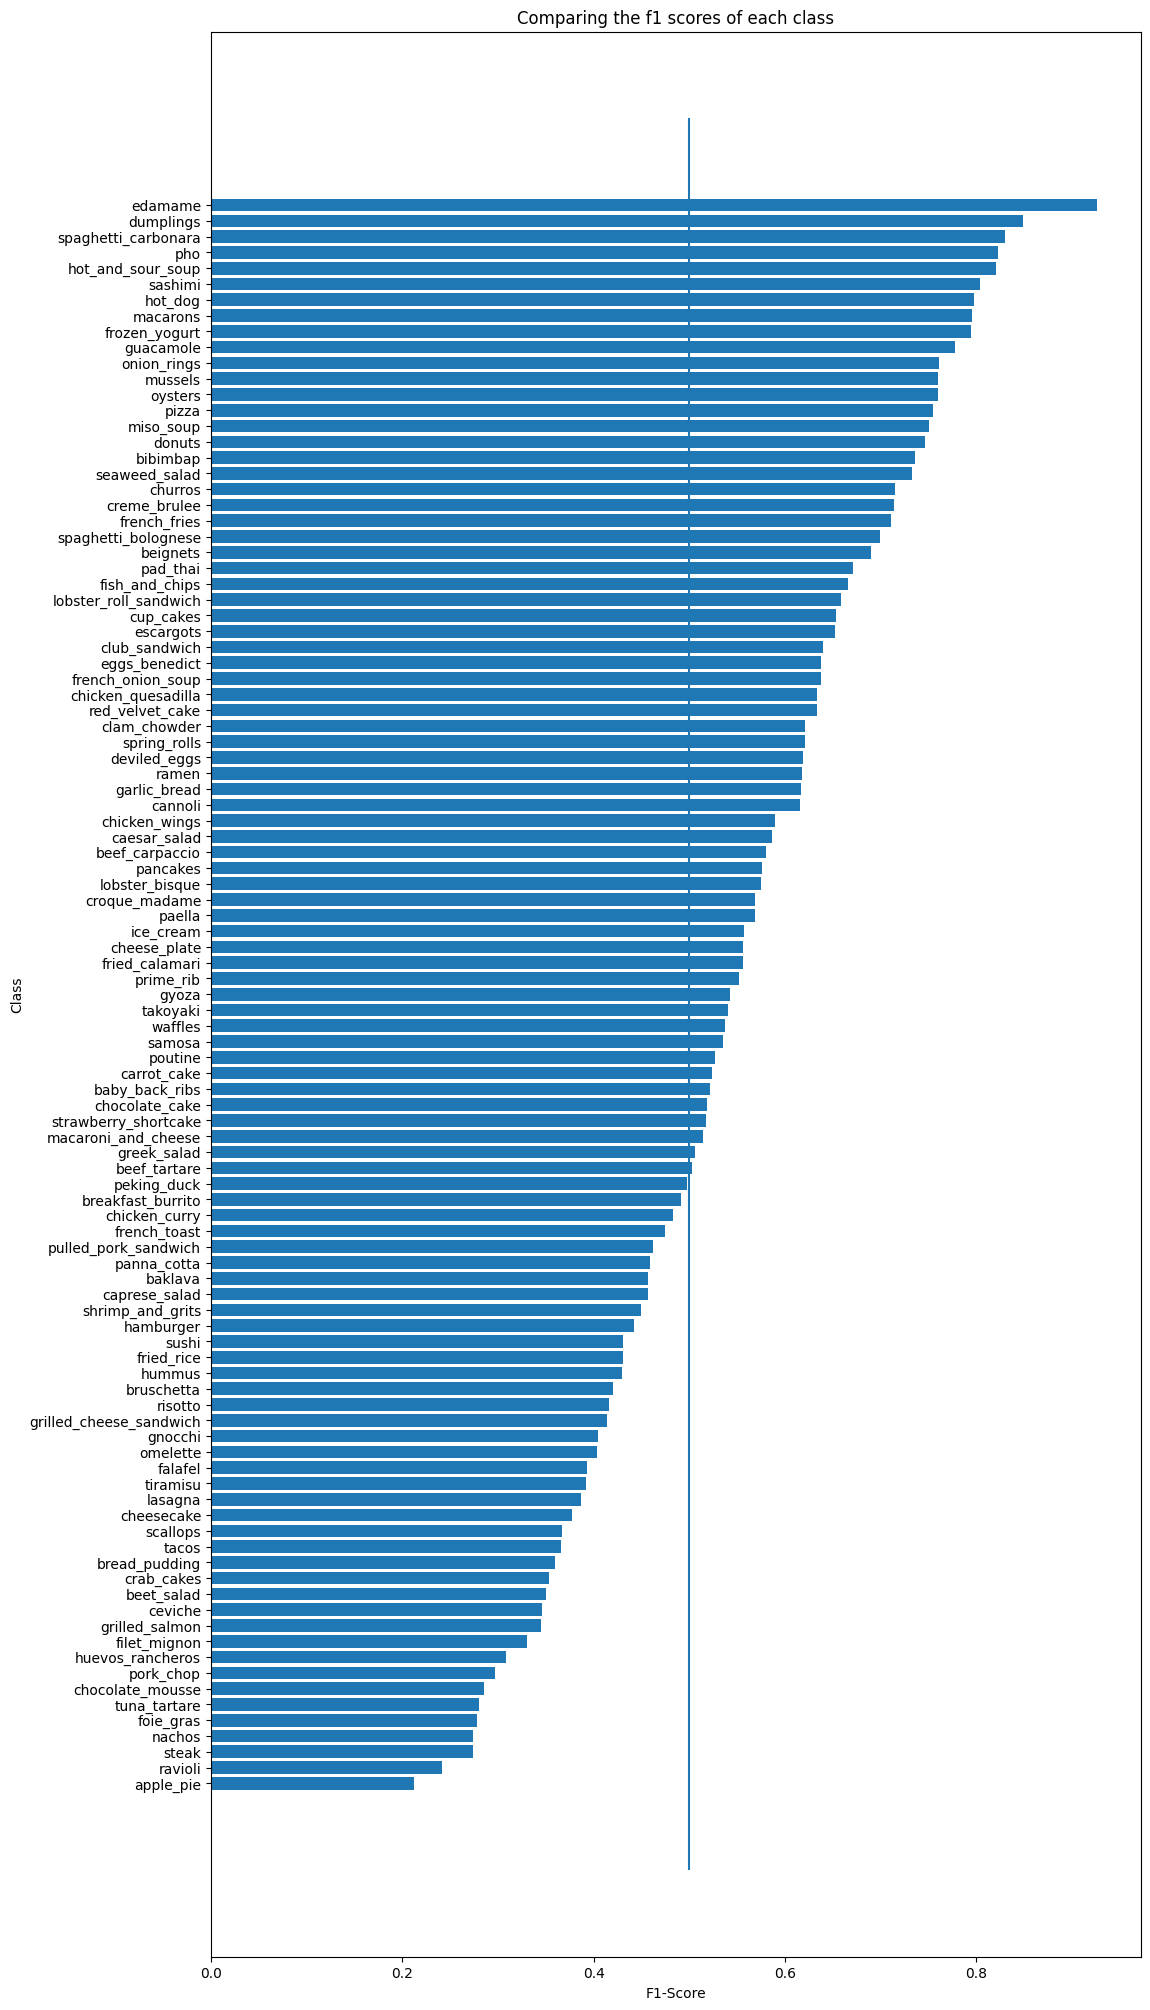

In [47]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(df)), df.F1_Score.values)
ax.plot([0.6-0.1, 0.6-0.1],
              plt.ylim(), label='Start Fine Tuning')
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df.class_names)
ax.set_xlabel('F1-Score')
ax.set_ylabel('Class')
ax.invert_yaxis()
ax.set_title('Comparing the f1 scores of each class')
# def autolabel(rects, ax):
# # Get y-axis height to calculate label position from.
#     (y_bottom, y_top) = ax.get_ylim()
#     y_height = y_top - y_bottom

#     for rect in rects:
#         height = rect.get_height()
#         # Fraction of axis height taken up by this rectangle
#         p_height = (height / y_height)
#         # If we can fit the label above the column, do that;
#         # otherwise, put it inside the column.
#         if p_height > 0.95: # arbitrary; 95% looked good to me.
#             label_position = height - (y_height * 0.05)
#         else:
#             label_position = height + (y_height * 0.01)

#         ax.text(rect.get_x() + rect.get_width() / 2., label_position,
#             '%d' % int(height),
#             ha='center', va='bottom')

# autolabel(scores, ax)

# Creating a function top prepare and load images to make predictions

In [93]:
def make_prediction(filename, y_hat, model=loaded_model, img_shape=224, class_names=test_data_all.class_names):
    img = tf.io.read_file(filename)

    # Decode the image into a tensor
    img = tf.image.decode_image(img, channels=3)  # Ensure 3 channels (RGB)

    # Resize the image to the expected input shape
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image to [0, 1]
    img_1 = img / 255.0

    # Expand dimensions to fit model input
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    preds = model.predict(img)

    # Print predictions for debugging
    # print("Predictions:", preds)

    # Get the class index with the highest probability
    predicted_class_index = tf.argmax(preds[0])

    # Map the class index to class name
    if class_names is not None:
        value = class_names[predicted_class_index]
    else:
        value = predicted_class_index.numpy()


    if y_hat == value:
      plt.imshow(img_1)
      plt.axis('off')
      plt.title(f'Prediction: {value}, True: {y_hat} Probability: {np.max(preds[0]):.2f}', c='g')
    else:
      plt.imshow(img_1)
      plt.axis('off')
      plt.title(f'Prediction: {value}, True: {y_hat} Probability: {np.max(preds[0]):.2f}', c='r')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


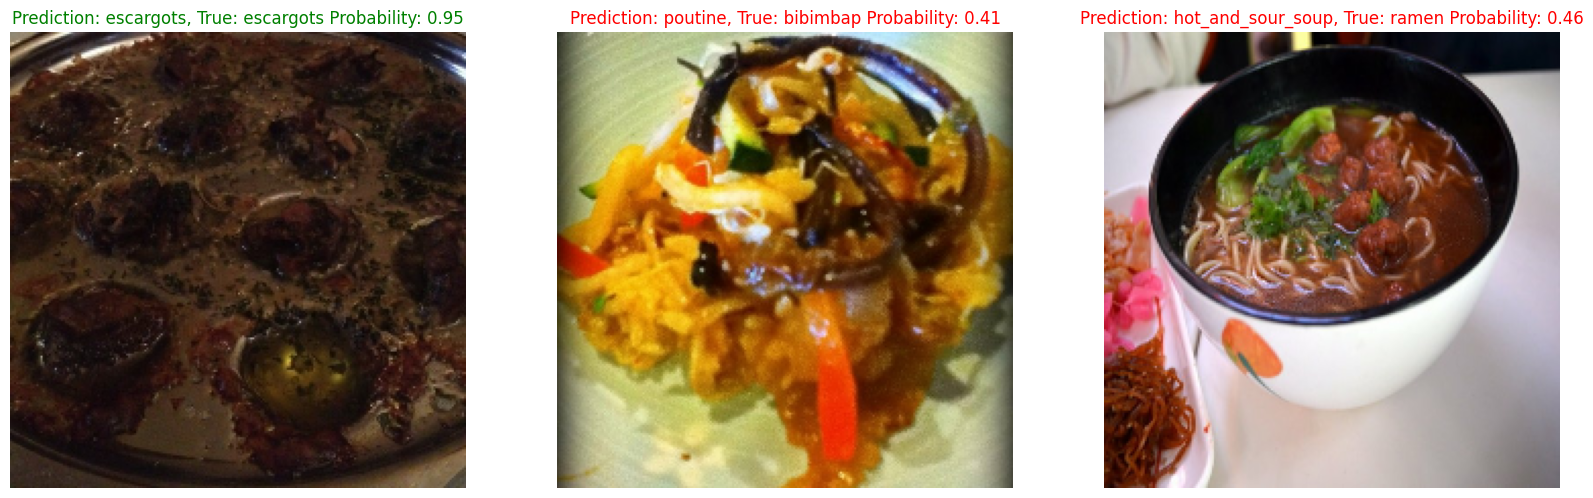

In [104]:
import random
import os
i = 1
plt.figure(figsize=(20, 20))
for j in range(3):
  plt.subplot(1,3,i)
  y_hat = random.choice(os.listdir('/content/101_food_classes_10_percent/test'))
  path = os.path.join('/content/101_food_classes_10_percent/test', y_hat)
  img_path = os.path.join(path, random.choice(os.listdir(path)))
  make_prediction(img_path, y_hat, loaded_model, 224)
  i += 1

# Finding the model's most wrong predictions

1. Get all the image filepaths in the test dataset List_files method
2. Create a pandas dataframe of the image truth labels, predicted classes, prediction probabilities and the max prediction probabilities
3. Use our DataFrame to find all the wrong predictions

